# Reservoir Computing Project #

## Imports ##

In [1]:
import numpy as np
import matplotlib.pyplot as plt


## Lorenz ##

In [2]:
from reservoirpy.datasets import lorenz
X = lorenz(n_timesteps=2000)

print(X)

[[ 1.          1.          1.        ]
 [ 1.1073228   1.79872164  0.96516196]
 [ 1.40967473  2.74000007  0.97272208]
 ...
 [-0.27309074 -0.50415907  8.98103121]
 [-0.35422832 -0.66790582  8.29546755]
 [-0.46425047 -0.88919121  7.66653225]]


### Normal Lorenz 2D ###

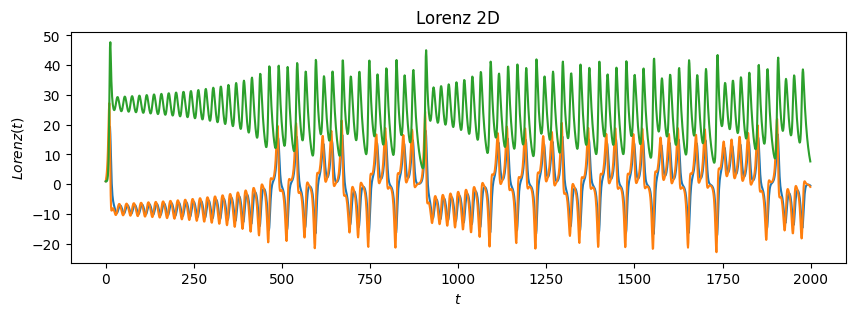

In [25]:
plt.figure(figsize=(10, 3))
plt.title("Lorenz 2D")
plt.ylabel("$Lorenz(t)$")
plt.xlabel("$t$")
plt.plot(X)
plt.show()

### 3D Lorenz ###

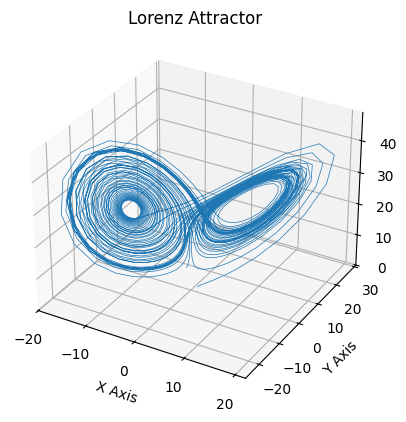

In [3]:
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*X.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

In [4]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(units=100, lr=0.3, sr=1.25)
readout = Ridge(output_dim=3, ridge=1e-5)

### Train ESN ####

In [6]:
esn = reservoir >> readout
predictions = esn.fit(X[:500], X[1:501]).run(X[500:])

Running Model-0: 500it [00:00, 7761.68it/s]           
Running Model-0: 100%|██████████| 1/1 [00:00<00:00, 14.70it/s]

Fitting node Ridge-0...


Running Model-0: 1500it [00:00, 6572.49it/s]          


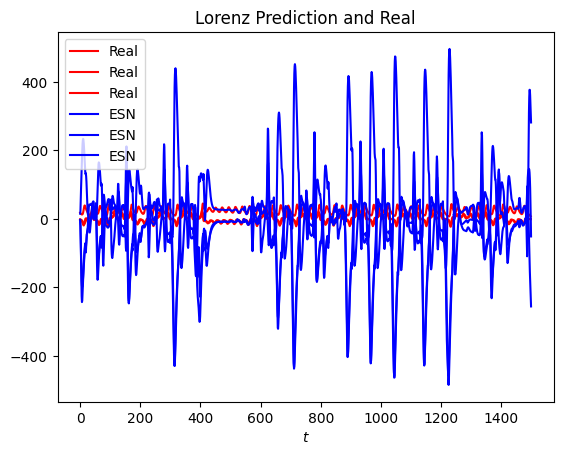

In [7]:
import numpy as np
import matplotlib.pyplot as plt
plt.title("Lorenz Prediction and Real")
plt.xlabel("$t$")
plt.plot(X[501:],label="Real",color="red")
plt.plot(predictions,label="ESN",color="blue")
plt.legend()
plt.show()

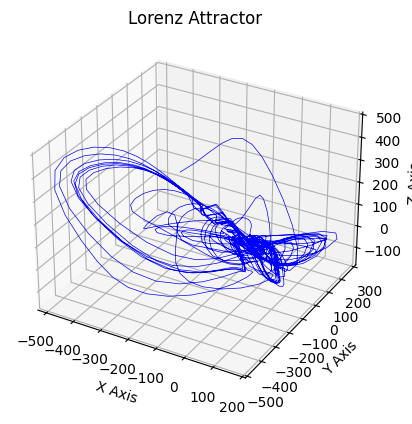

In [8]:
ax = plt.figure().add_subplot(projection='3d')

#ax.plot(*X[501:].T,label="Real",color="red", lw=0.5)
ax.plot(*predictions.T,label="ESN",color="blue", lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

### Optimization ###

In [65]:
from reservoirpy.observables import nrmse, rsquare
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, input_scaling, N, sr, lr, ridge, seed):
    # This step may vary depending on what you put inside 'dataset'
    x_train, y_train, x_test, y_test = dataset

    # You can access anything you put in the config
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]

    # The seed should be changed across the instances,
    # to be sure there is no bias in the results
    # due to initialization.
    variable_seed = seed

    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(
            units=int(N),
            sr=sr,
            lr=lr,
            input_scaling=input_scaling,
            seed=variable_seed
        )

        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(x_train, y_train) \
                           .run(x_test)

        loss = nrmse(y_test, predictions, norm_value=np.ptp(x_train))
        r2 = rsquare(y_test, predictions)

        # Change the seed between instances
        variable_seed += 1

        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [66]:
import json

hyperopt_config = {
    "exp": "hyperopt-lorenz",    # the experimentation name
    "hp_max_evals": 200,              # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",            # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                       # the random state seed, to ensure reproducibility
    "instances_per_trial": 5,         # how many random ESN will be tried with each sets of parameters
    "hp_space": {                     # what are the ranges of parameters explored
        "N": ["loguniform", 10, 1000],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],    # idem with the leaking rate, from 1e-3 to 1
        "input_scaling": ["choice", 1.0], # the input scaling is fixed
        "ridge": ["loguniform", 1e-8, 1e1],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [67]:
train_len = 500
forecast = 2

X_train = X[:train_len]
Y_train = X[forecast : train_len + forecast]

X_test = X[train_len : -forecast]
Y_test = X[train_len + forecast:]

dataset = (X_train, Y_train, X_test, Y_test)

In [68]:
from reservoirpy.datasets import to_forecasting

X_train, X_test, Y_train, Y_test = to_forecasting(X, forecast=forecast, test_size=train_len-forecast)

In [69]:
%%capture
from reservoirpy.hyper import research
best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

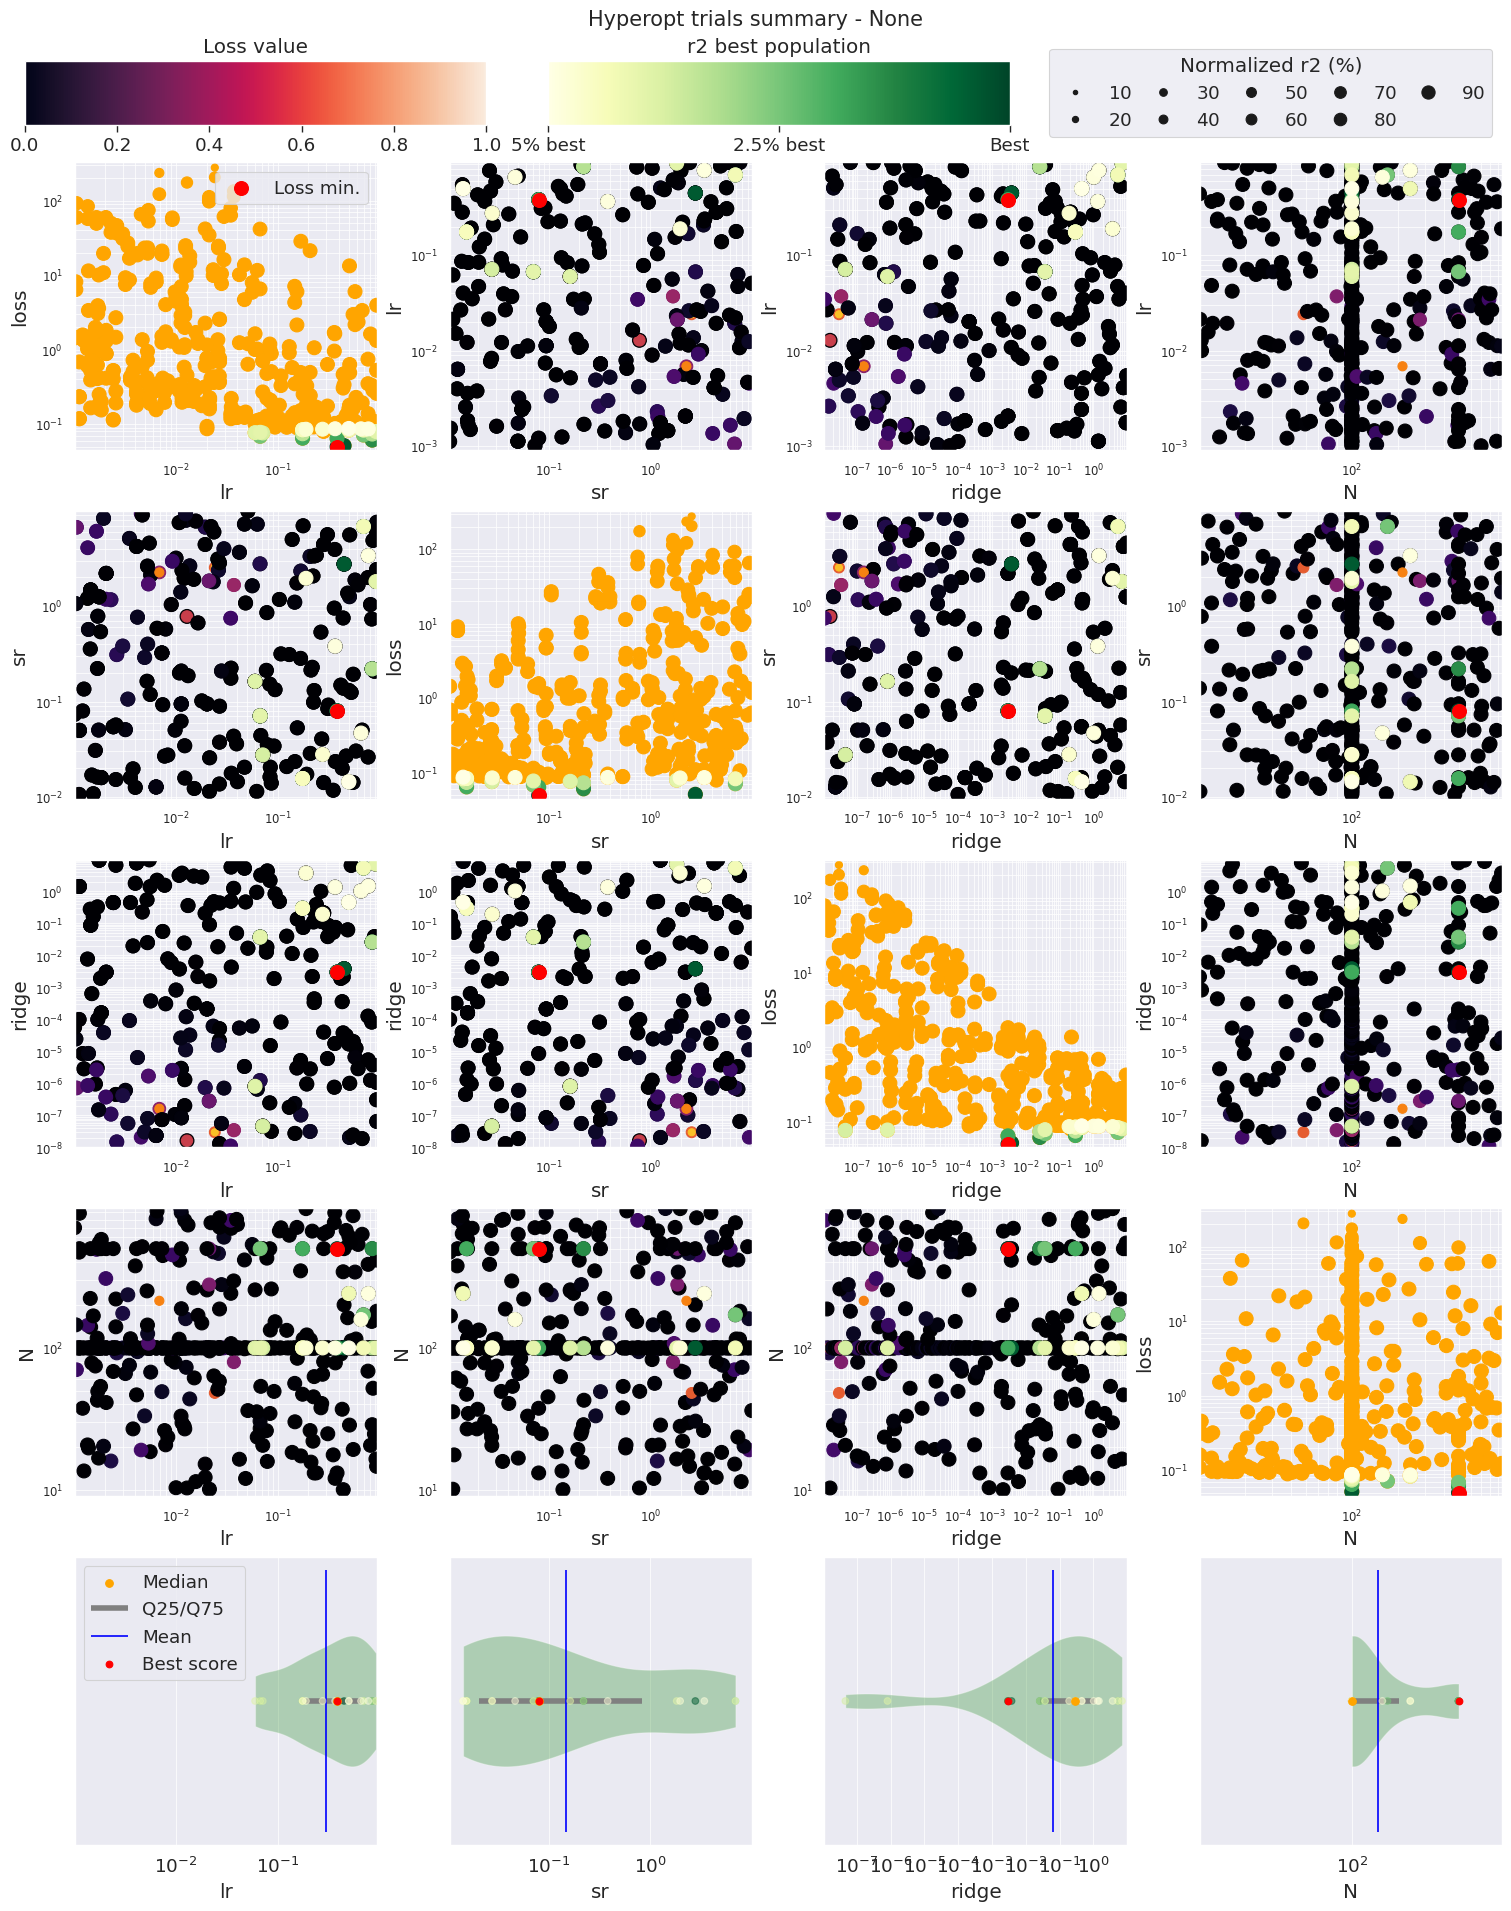

In [71]:
from reservoirpy.hyper import plot_hyperopt_report
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge","N"), metric="r2")

### Optimized ####

In [72]:
from reservoirpy.nodes import Reservoir, Ridge
reservoir = Reservoir(units=500, lr=0.4, sr=8e-2)
readout = Ridge(output_dim=3, ridge=3e-3)

esn = reservoir >> readout
predictions = esn.fit(X[:500], X[1:501]).run(X[500:])




Running Model-2309:   0%|          | 0/1 [00:00<?, ?it/s]

Running Model-2309: 500it [00:00, 5384.34it/s]           
Running Model-2309: 100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


Fitting node Ridge-2309...


Running Model-2309: 1500it [00:00, 5662.18it/s]          


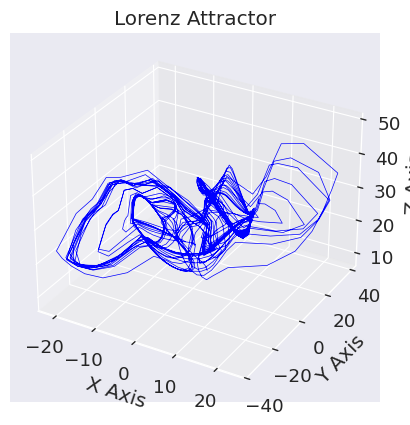

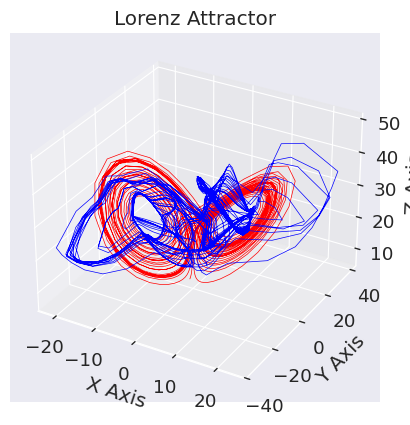

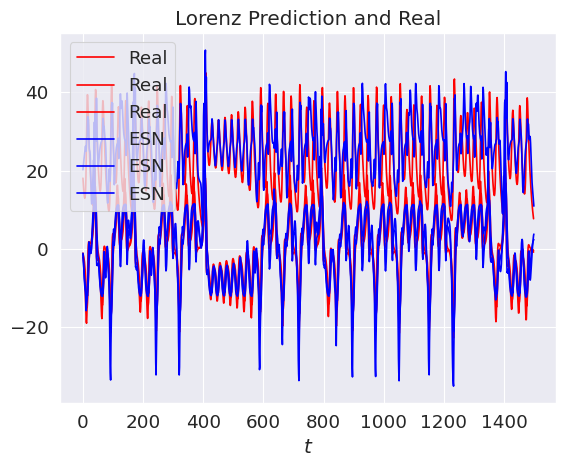

In [76]:
ax = plt.figure().add_subplot(projection='3d')
#ax.plot(*X[501:].T,label="Real",color="red", lw=0.5)
ax.plot(*predictions.T,label="ESN",color="blue", lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*X[501:].T,label="Real",color="red", lw=0.5)
ax.plot(*predictions.T,label="ESN",color="blue", lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

plt.title("Lorenz Prediction and Real")
plt.xlabel("$t$")
plt.plot(X[501:],label="Real",color="red")
plt.plot(predictions,label="ESN",color="blue")
plt.legend()
plt.show()

## Sine wave ##

In [77]:
X = np.sin(np.linspace(0, 6*np.pi, 100)).reshape(-1,1)

### Normal sine wave ###

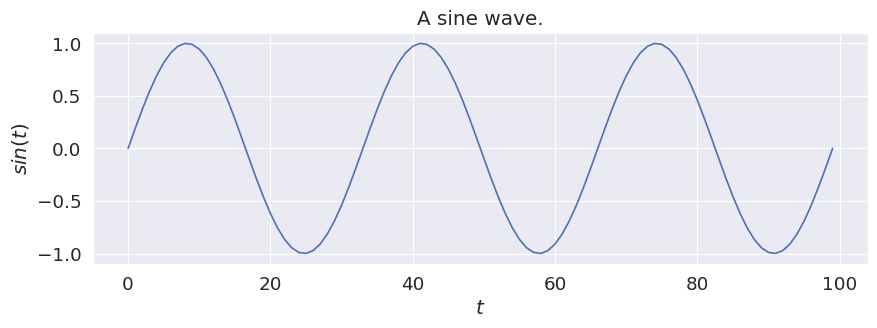

In [78]:
plt.figure(figsize=(10, 3))
plt.title("A sine wave.")
plt.ylabel("$sin(t)$")
plt.xlabel("$t$")
plt.plot(X)
plt.show()
X_train = X[:50]
Y_train = X[1:51]


In [79]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(100, lr=0.5, sr=0.9)
readout = Ridge(ridge=1e-7)

esn_model = reservoir >> readout

### Train ESN ###

In [80]:
esn_model = esn_model.fit(X_train, Y_train, warmup=10)
print(reservoir.is_initialized, readout.is_initialized, readout.fitted)

Running Model-2310: 50it [00:00, 6788.22it/s]            
Running Model-2310: 100%|██████████| 1/1 [00:00<00:00, 103.32it/s]


Fitting node Ridge-2310...
True True True


### Run ESN ###

Running Model-2310: 50it [00:00, 6985.85it/s]            


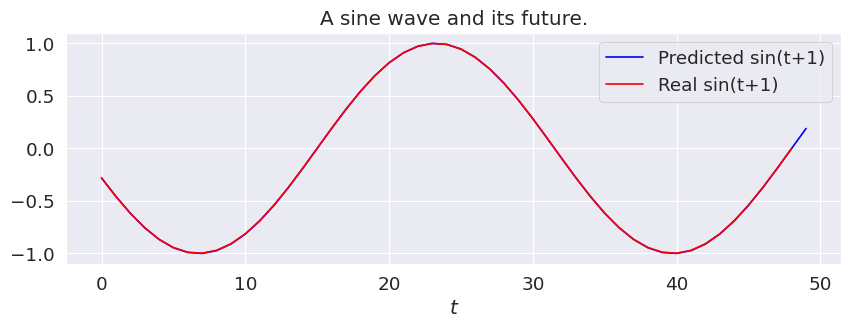

In [81]:
Y_pred = esn_model.run(X[50:])

plt.figure(figsize=(10, 3))
plt.title("A sine wave and its future.")
plt.xlabel("$t$")
plt.plot(Y_pred, label="Predicted sin(t+1)", color="blue")
plt.plot(X[51:], label="Real sin(t+1)", color="red")
plt.legend()
plt.show()
